In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data to the range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension (for Conv2D input)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (60000, 28, 28, 1), y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1), y_test shape: (10000, 10)


In [3]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Save initial weights for later
initial_weights = model.get_weights()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9052 - loss: 0.3015 - val_accuracy: 0.9850 - val_loss: 0.0445
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9846 - loss: 0.0481 - val_accuracy: 0.9901 - val_loss: 0.0310
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9912 - loss: 0.0260 - val_accuracy: 0.9912 - val_loss: 0.0247
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9933 - loss: 0.0207 - val_accuracy: 0.9917 - val_loss: 0.0263
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9954 - loss: 0.0137 - val_accuracy: 0.9905 - val_loss: 0.0290
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9969 - loss: 0.0093 - val_accuracy: 0.9898 - val_loss: 0.0302
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9927 - val_loss: 0.0278
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9982 - loss: 0.0060

In [4]:
original_loss, original_acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - 2ms/step - accuracy: 0.9905 - loss: 0.0351


In [5]:
# Define a pruning function
def prune_weights(model, pruning_percentage):
    """
    Prunes the model by removing the smallest magnitude weights.

    Args:
        model: Trained model to prune.
        pruning_percentage: Percentage of weights to prune (0-100).

    Returns:
        The pruned model.
    """
    for layer in model.layers:
        if isinstance(layer, layers.Dense) or isinstance(layer, layers.Conv2D):
            weights, biases = layer.get_weights()
            # Flatten weights and find the pruning threshold
            abs_weights = np.abs(weights)
            threshold = np.percentile(abs_weights, pruning_percentage)

            # Prune weights below the threshold
            pruned_weights = np.where(abs_weights < threshold, 0, weights)

            # Set pruned weights back to the layer
            layer.set_weights([pruned_weights, biases])
    return model


In [6]:
# Function to train and evaluate pruned models
def train_pruned_model(pruning_percentage, initial_weights):
    # Prune and reinitialize
    pruned_model = prune_weights(model, pruning_percentage)
    pruned_model.set_weights(initial_weights)

    # Retrain the pruned model
    pruned_model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0, validation_data=(x_test, y_test))

    # Evaluate the pruned model
    _, pruned_acc = pruned_model.evaluate(x_test, y_test, verbose=0)
    return pruned_acc


In [7]:
# Print the structure of initial_weights
for i, layer_weights in enumerate(initial_weights):
    print(f"Layer {i} - Weights Shape: {[w.shape for w in layer_weights if hasattr(w, 'shape')]}")


Layer 0 - Weights Shape: [(3, 1, 32), (3, 1, 32), (3, 1, 32)]
Layer 1 - Weights Shape: [(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]
Layer 2 - Weights Shape: [(3, 32, 64), (3, 32, 64), (3, 32, 64)]
Layer 3 - Weights Shape: [(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]
Layer 4 - Weights Shape: [(128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (12

Testing pruning percentage: 10%
Accuracy after pruning 10%: 0.9905999898910522
Testing pruning percentage: 25%
Accuracy after pruning 25%: 0.9900000095367432
Testing pruning percentage: 50%
Accuracy after pruning 50%: 0.9908999800682068
Testing pruning percentage: 75%
Accuracy after pruning 75%: 0.9886000156402588
Testing pruning percentage: 90%
Accuracy after pruning 90%: 0.9894999861717224
Testing pruning percentage: 99%
Accuracy after pruning 99%: 0.9896000027656555


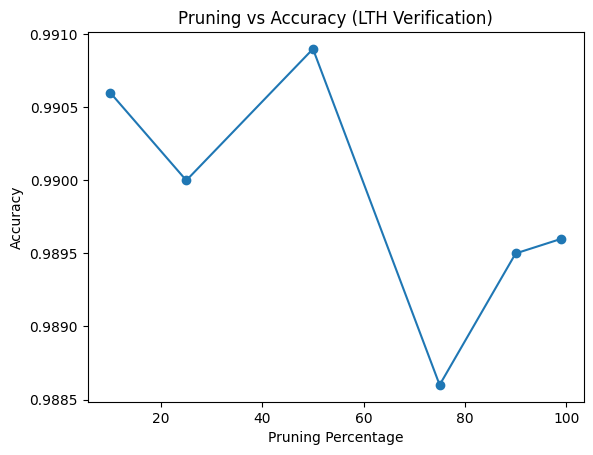

In [8]:
# Test various pruning percentages
pruning_percentages = [10, 25, 50, 75, 90, 99]
accuracies = []

for pruning_percentage in pruning_percentages:
    print(f"Testing pruning percentage: {pruning_percentage}%")
    acc = train_pruned_model(pruning_percentage, initial_weights)
    accuracies.append(acc)
    print(f"Accuracy after pruning {pruning_percentage}%: {acc}")

# Plot pruning percentage vs accuracy
plt.plot(pruning_percentages, accuracies, marker='o')
plt.xlabel("Pruning Percentage")
plt.ylabel("Accuracy")
plt.title("Pruning vs Accuracy (LTH Verification)")
plt.show()


In [9]:
# Evaluate the original model
print(f"Original Model Accuracy: {original_acc}")

# Print results for comparison
for i, pruning_percentage in enumerate(pruning_percentages):
    print(f"Pruning {pruning_percentage}%: Accuracy = {accuracies[i]}")


Original Model Accuracy: 0.9904999732971191
Pruning 10%: Accuracy = 0.9905999898910522
Pruning 25%: Accuracy = 0.9900000095367432
Pruning 50%: Accuracy = 0.9908999800682068
Pruning 75%: Accuracy = 0.9886000156402588
Pruning 90%: Accuracy = 0.9894999861717224
Pruning 99%: Accuracy = 0.9896000027656555
